In [136]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import textblob
import pandas
import numpy as np
import nltk
from numpy import array
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
import json
from textblob import TextBlob
import ast

%matplotlib inline

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [147]:
label_data = pandas.read_table('ground_truth.txt', dtype=str)#, header=None, names = ["tweetID","label"])
label_data.dtypes
raw_data = pandas.read_table('raw_tweets.txt', dtype=str)#, header=None, names = ["tweetID","text"])
memo_for = pandas.read_table('memos/Memo1.txt',dtype=str, header=None, names = ["memo"])
memo_against = pandas.read_table('memos/Memo2.txt',dtype=str, header=None, names = ["memo"])
memo_neutral = pandas.read_table('memos/Memo4.txt',dtype=str, header=None, names = ["memo"])
raw_data.dtypes
frames = [label_data, raw_data]
data = pandas.merge(label_data,raw_data,on="Tweet ID")
data.columns = ['ID','label','text']
print(data)
#print(memo_for)

                     ID             label  \
0    660810089696067585           Neutral   
1    626801870871199744  Against Abortion   
2    771497131341389824  Against Abortion   
3    578308403023486976  Against Abortion   
4    585645743727374336  Against Abortion   
5    639086995399159810  Against Abortion   
6    688367316065718273  Against Abortion   
7    672784943987208192  Against Abortion   
8    649130972479418368  Against Abortion   
9    682167318210727936  Against Abortion   
10   598810158945345536           Neutral   
11   629002425513459712  Against Abortion   
12   601855385008525312  Against Abortion   
13   689616902151274496      For Abortion   
14   631210363988500480  Against Abortion   
15   645086879520419841  Against Abortion   
16   676217552402571264  Against Abortion   
17   738327811606253568  Against Abortion   
18   754447555153453056           Neutral   
19   611584057537794048           Neutral   
20   598505773694656512  Against Abortion   
21   75740

In [148]:
data.dtypes

ID       object
label    object
text     object
dtype: object

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,174.0,129.316092,39.445991,34.0,113.25,130.5,139.75,326.0
For Abortion,137.0,135.781022,44.906228,17.0,116.00,135.0,151.00,254.0
Neutral,101.0,140.277228,49.538494,44.0,120.00,136.0,142.00,308.0


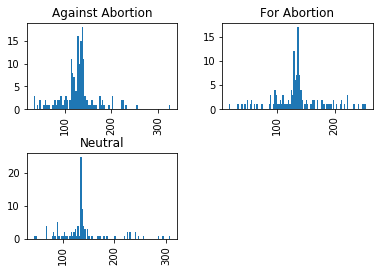

In [149]:
data["length"] = data.apply(lambda row: len(row.text), axis=1)

data.hist(column='length', by='label', bins=100)
data.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,174.0,0.160920,0.477798,0.0,0.0,0.0,0.0,4.0
For Abortion,137.0,0.087591,0.308565,0.0,0.0,0.0,0.0,2.0
Neutral,101.0,0.376238,3.190146,0.0,0.0,0.0,0.0,32.0


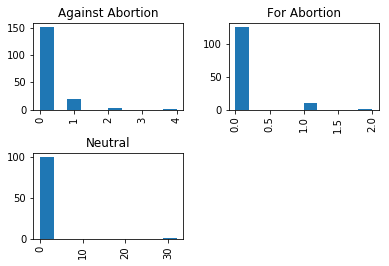

In [150]:
data["exclaim"] = data.apply(lambda row: row.text.count('!'), axis=1)
data.hist(column='exclaim', by='label', bins=10)
data.groupby('label').exclaim.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Against Abortion,174.0,11.701149,14.244857,0.0,5.0,9.0,14.75,113.0
For Abortion,137.0,9.532847,6.625542,0.0,5.0,8.0,13.00,34.0
Neutral,101.0,11.376238,8.865497,1.0,6.0,10.0,14.00,66.0


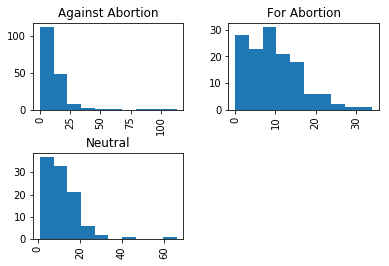

In [151]:
data["capital"] = data.apply(lambda row: sum(1 for c in row.text if c.isupper()), axis=1)
data.hist(column='capital', by='label', bins=10)
data.groupby('label').capital.describe()

In [152]:
def tag_and_sentiment(row,memo):
    blob = TextBlob(row.text)
    memo_spl = memo.split(' @ ')[0]
    memo_emo = memo.split(' @ ')[1]
    if(((blob.sentiment.polarity>=0.5 and memo_emo == 'Positive') or (blob.sentiment.polarity<0.5 and memo_emo == 'Negative')) and memo_spl.lower() in row.text.lower()):
        return 1
    else:
        return 0
    

In [153]:
feature_vec = pandas.DataFrame()
for i, memo_row in memo_for.iterrows():
    if ' @ ' in memo_row.memo:
        data[memo_row.memo] = data.apply(tag_and_sentiment, memo=memo_row.memo, axis=1 )
    elif ' + ' in memo_row.memo:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.split(' + ')[0].lower() in row.text.lower() and memo_row.memo.split(' + ')[1].lower() in row.text.lower()), axis=1 )
    else:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.lower() in row.text.lower()), axis=1 )

print(data)
#     for j, memo_row in memo_for.iterrows():
        
#     if row['B'] > 1.5:
#         calc_temp   = row['A'] *10
#         calc_temp01 = row['C'] *-10
# data["poundsymb"] = data.apply(lambda row: row.message.count('£'), axis=1)


                     ID             label  \
0    660810089696067585           Neutral   
1    626801870871199744  Against Abortion   
2    771497131341389824  Against Abortion   
3    578308403023486976  Against Abortion   
4    585645743727374336  Against Abortion   
5    639086995399159810  Against Abortion   
6    688367316065718273  Against Abortion   
7    672784943987208192  Against Abortion   
8    649130972479418368  Against Abortion   
9    682167318210727936  Against Abortion   
10   598810158945345536           Neutral   
11   629002425513459712  Against Abortion   
12   601855385008525312  Against Abortion   
13   689616902151274496      For Abortion   
14   631210363988500480  Against Abortion   
15   645086879520419841  Against Abortion   
16   676217552402571264  Against Abortion   
17   738327811606253568  Against Abortion   
18   754447555153453056           Neutral   
19   611584057537794048           Neutral   
20   598505773694656512  Against Abortion   
21   75740

In [154]:
for i, memo_row in memo_against.iterrows():
    if ' @ ' in memo_row.memo:
        data[memo_row.memo] = data.apply(tag_and_sentiment, memo=memo_row.memo, axis=1 )
    elif ' + ' in memo_row.memo:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.split(' + ')[0].lower() in row.text.lower() and memo_row.memo.split(' + ')[1].lower() in row.text.lower()), axis=1 )
    else:
        data[memo_row.memo] = data.apply(lambda row: int(memo_row.memo.lower() in row.text.lower()), axis=1 )


In [164]:
class CapitalCountExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self, df, y=None):
        return np.array([sum(1 for c in row if c.isupper()) for row in df])[:,np.newaxis]

    def fit(self, df, y=None):
        return self


vectorizer = FeatureUnion([
        ('cv', CountVectorizer(stop_words='english',max_features=500)),
        ('capital_count', CapitalCountExtractor())
    ])

In [172]:
vectorizer = CountVectorizer(stop_words='english',max_features=500)
vectorizer = FeatureUnion([
        ('cv', CountVectorizer(stop_words='english',max_features=500)),
        ('capital_count', CapitalCountExtractor())
    ])

train_data = data.sample(frac=0.8, random_state=200)
test_data = data.drop(train_data.index)
#train_data, test_data = train_test_split(data, test_size=0.2)
#print(data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '])
train_data_bow = vectorizer.fit_transform(train_data['text']).toarray()
print(train_data_bow.shape)

train_data_memos = train_data.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
print(train_data_memos.shape)

train_data_feature_vec = np.concatenate((train_data_bow, train_data_memos), axis=1)
print(train_data_feature_vec.shape)

pca = PCA(n_components=5)
train_data_memos_reduced = pca.fit(train_data_memos)
svm_tweetDetector = svm.SVC(kernel='linear')
lb = preprocessing.LabelBinarizer()
y_train = np.array([number[0] for number in lb.fit_transform(train_data["label"])])


(330, 501)
(330, 51)
(330, 552)


In [173]:
scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='f1',cv=10)
print('F-1 over 10 folds: ')
f1_scores = pandas.DataFrame(scores)
print(f1_scores)
print('Aggregate F-1 score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='precision', cv=10)
print('Precision over 10 folds: ')
precision_scores = pandas.DataFrame(scores)
print(precision_scores)
print('Aggregate precision score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='recall', cv=10)
print('Recall over 10 folds: ')
recall_scores = pandas.DataFrame(scores)
print(recall_scores)
print('Aggregate recall score: ',scores.mean())

scores = model_selection.cross_val_score(svm_tweetDetector, train_data_feature_vec, y_train, scoring ='accuracy', cv=10)
print('Accuracy over 10 folds: ')
accuracy_scores = pandas.DataFrame(scores)
print(accuracy_scores)
print('Aggregate accuracy score: ',scores.mean())

F-1 over 5 folds: 
          0
0  0.666667
1  0.740741
2  0.727273
3  0.750000
4  0.695652
5  0.814815
6  0.714286
7  0.888889
8  0.640000
9  0.720000
Aggregate F-1 score:  0.7358321726582596
Precision over 5 folds: 
          0
0  0.692308
1  0.769231
2  0.631579
3  0.900000
4  0.888889
5  0.846154
6  0.714286
7  0.923077
8  0.727273
9  0.818182
Aggregate precision score:  0.7910977326766802
Recall over 5 folds: 
          0
0  0.642857
1  0.714286
2  0.857143
3  0.642857
4  0.571429
5  0.785714
6  0.714286
7  0.857143
8  0.571429
9  0.642857
Aggregate recall score:  0.7000000000000001
Accuracy over 5 folds: 
          0
0  0.727273
1  0.787879
2  0.727273
3  0.818182
4  0.787879
5  0.848485
6  0.757576
7  0.909091
8  0.727273
9  0.787879
Aggregate accuracy score:  0.7878787878787878


In [39]:
# data.hist(column='length', by='tag', bins=100)
# data.groupby('tag').length.describe()

In [40]:
#data["poundsymb"] =data.apply(lambda row: row.message.count('£'), axis=1)

In [41]:
# data.hist(column='poundsymb', by='tag', bins=10)
# data.groupby('tag').poundsymb.describe()

In [42]:
#for index, row in data.iterrows():
#   row.message = PorterStemmer().stem(row.message)
#print(data)

In [178]:
# train_data = data.sample(frac=0.8, random_state=200)
# test_data = data.drop(train_data.index)


#print(len(train_data))
#print(len(test_data))
#X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(train_data_bow, train_data["tag"], test_size=0.2,random_state=109)

kfold = KFold(n_splits=10, random_state=None, shuffle=True)


#print(kfold.get_n_splits(data))

#train_messages = train_data['message']

#for index, row in train_data.iterrows():
#    row.message = re.sub('[^A-Za-z]', ' ', row.message)

# class CurrencyExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def transform(self, df, y=None):
#         return np.array([row.count('£') for row in df])[:,np.newaxis]

#     def fit(self, df, y=None):
#         return self


#vectorizer = CountVectorizer(stop_words='english',max_features=500)

# vectorizer = FeatureUnion([
#         ('cv', CountVectorizer(stop_words='english',max_features=500)),
#         ('pound_sym', CurrencyExtractor())
#     ])


#train_data_bow.shape

# pipeline_svm = Pipeline([
#     ('bow', vectorizer),
#     ('classifier', svm.SVC(kernel='linear')),
# ])

#train_data_bow.shape

for train_index, test_index in kfold.split(train_data):
    trainData = train_data.iloc[train_index]
    testData = train_data.iloc[test_index]
    #print(len(trainData))
    #print(len(testData))
    train_data_bow = vectorizer.fit_transform(trainData['text']).toarray()
    train_data_memos = trainData.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
    train_data_feature_vec = np.concatenate((train_data_bow, train_data_memos), axis=1)

    svm_tweetDetector = svm.SVC(kernel='linear').fit(train_data_feature_vec, trainData["label"])
    
    test_data_bow = vectorizer.transform(testData['text']).toarray()
    test_data_memos = testData.loc[:, 'Horrible Anti-Abortion':'#PraytoEndAbortion '].values
    test_data_feature_vec = np.concatenate((test_data_bow, test_data_memos), axis=1)
    y_pred = svm_tweetDetector.predict(test_data_feature_vec)
    
    #logreg_spamDetector = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    #logreg_spamDetector = logreg_spamDetector.fit(train_data_bow, trainData["tag"])
    #y_pred = logreg_spamDetector.predict(vectorizer.transform(testData['message']).toarray())
    
#     randomForest_spamDetector = RandomForestClassifier(n_jobs=2, random_state=0)
#     randomForest_spamDetector.fit(train_data_bow, trainData["tag"])
#     y_pred = randomForest_spamDetector.predict(vectorizer.transform(testData['message']).toarray())
    
    accuracy = accuracy_score(testData["label"],y_pred)
    print('Accuracy: ', accuracy)
    precision = precision_score(testData["label"],y_pred,average=None)
    print('Precision: ', precision)
    recall = recall_score(testData["label"],y_pred,average=None)
    print('Recall: ', recall)
    f1 = f1_score(testData["label"],y_pred,average=None)
    print('F1:',f1, '\n')

train_data_feature_vec = vectorizer.fit_transform(train_data['text']).toarray()


# # logreg_spamDetector = linear_model.LogisticRegression(n_jobs=1, C=1e5)
# # logreg_spamDetector = logreg_spamDetector.fit(train_data_bow, train_data["tag"])
# # scores = model_selection.cross_val_score(logreg_spamDetector, train_data_bow, train_data["tag"], cv=5)
# # print(scores)


# svm_spamDetector = svm.SVC(kernel='linear')
# lb = preprocessing.LabelBinarizer()

# y_train = np.array([number[0] for number in lb.fit_transform(train_data["tag"])])

# print('SVM')
# print("Test set metrics")
# svm_spamDetector = svm.SVC(kernel='linear').fit(train_data_bow, train_data["tag"])
# y_pred = svm_spamDetector.predict(vectorizer.transform(test_data['message']).toarray())
# accuracy = accuracy_score(test_data["tag"],y_pred)
# print('Accuracy: ', accuracy)
# precision = precision_score(test_data["tag"],y_pred,average=None)
# print('Precision: ', precision)
# recall = recall_score(test_data["tag"],y_pred,average=None)
# print('Recall: ', recall)
# f1 = f1_score(test_data["tag"],y_pred,average=None)
# print('F1:',f1, '\n')

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='f1',cv=5)
# print('F-1 over 5 folds: ')
# f1_scores = pandas.DataFrame(scores)
# print(f1_scores)
# print('Aggregate F-1 score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='precision', cv=5)
# print('Precision over 5 folds: ')
# precision_scores = pandas.DataFrame(scores)
# print(precision_scores)
# print('Aggregate precision score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='recall', cv=5)
# print('Recall over 5 folds: ')
# recall_scores = pandas.DataFrame(scores)
# print(recall_scores)
# print('Aggregate recall score: ',scores.mean())

# scores = model_selection.cross_val_score(svm_spamDetector, train_data_bow, y_train, scoring ='accuracy', cv=5)
# print('Accuracy over 5 folds: ')
# accuracy_scores = pandas.DataFrame(scores)
# print(accuracy_scores)
# print('Aggregate accuracy score: ',scores.mean())


# print('Random forest classifier')
# print("Test set metrics")
# randomForest_spamDetector = RandomForestClassifier(n_jobs=2, random_state=0)
# randomForest_spamDetector.fit(train_data_bow, train_data["tag"])
# y_pred = randomForest_spamDetector.predict(vectorizer.transform(test_data['message']).toarray())

# accuracy = accuracy_score(test_data["tag"],y_pred)
# print('Accuracy: ', accuracy)
# precision = precision_score(test_data["tag"],y_pred,average=None)
# print('Precision: ', precision)
# recall = recall_score(test_data["tag"],y_pred,average=None)
# print('Recall: ', recall)
# f1 = f1_score(test_data["tag"],y_pred,average=None)
# print('F1:',f1, '\n')



# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='f1',cv=5)
# print('F-1 over 5 folds: ')
# f1_scores = pandas.DataFrame(scores)
# print(f1_scores)
# print('Aggregate F-1 score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='precision', cv=5)
# print('Precision over 5 folds: ')
# precision_scores = pandas.DataFrame(scores)
# print(precision_scores)
# print('Aggregate precision score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='recall', cv=5)
# print('Recall over 5 folds: ')
# recall_scores = pandas.DataFrame(scores)
# print(recall_scores)
# print('Aggregate recall score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, y_train, scoring ='accuracy', cv=5)
# print('Accuracy over 5 folds: ')
# accuracy_scores = pandas.DataFrame(scores)
# print(accuracy_scores)
# print('Aggregate accuracy score: ',scores.mean())

# scores = model_selection.cross_val_score(randomForest_spamDetector, train_data_bow, train_data["tag"], cv=5)
# print(scores)


#    classifier = nltk.NaiveBayesClassifier.train(train_data)
#    sum += nltk.classify.accuracy(classifier, test_data)
#average = sum/3


#train_data_bow.shape

#print(train_data_bow)
#print(vectorizer.get_feature_names())

#word_count_bag = CountVectorizer.fit_transform(corpus)
#print(word_count_bag.toarray())
#print(vectorizer.get_feature_names())
#word_count_bag.shape

#print(train_data["tag"])

#svm_spamDetector = svm.SVC(kernel='linear').fit(train_data_bow, train_data["tag"])

#test = vectorizer.transform(["Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16"]).toarray()
#test.shape
#svm_spamDetector.predict(vectorizer.transform(["Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16"]).toarray())[0]

Accuracy:  0.696969696969697
Precision:  [0.8        0.61538462 0.6       ]
Recall:  [0.66666667 0.88888889 0.5       ]
F1: [0.72727273 0.72727273 0.54545455] 

Accuracy:  0.5151515151515151
Precision:  [0.45454545 0.4        0.66666667]
Recall:  [0.41666667 0.57142857 0.57142857]
F1: [0.43478261 0.47058824 0.61538462] 

Accuracy:  0.5151515151515151
Precision:  [0.55555556 0.42857143 0.5       ]
Recall:  [0.83333333 0.33333333 0.33333333]
F1: [0.66666667 0.375      0.4       ] 

Accuracy:  0.7272727272727273
Precision:  [0.76923077 0.86666667 0.2       ]
Recall:  [0.83333333 0.86666667 0.16666667]
F1: [0.8        0.86666667 0.18181818] 

Accuracy:  0.6666666666666666
Precision:  [0.71428571 0.66666667 0.6       ]
Recall:  [0.66666667 0.54545455 0.85714286]
F1: [0.68965517 0.6        0.70588235] 

Accuracy:  0.5454545454545454
Precision:  [0.76470588 0.375      0.25      ]
Recall:  [0.68421053 0.375      0.33333333]
F1: [0.72222222 0.375      0.28571429] 

Accuracy:  0.5151515151515151